# Simulation-reality-gap

In [21]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Get the current directory of the notebook
current_dir = os.path.dirname(os.path.abspath('__file__'))
# Get the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
# Add the parent directory to sys.path
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from mkp_delays_rlfake_mkp_delays import FakeMKPdelays

# update some global settings for plots
plt.rcParams.update({
    'font.family': 'sans-serif',  
    'font.size': 11, 
    'font.weight': 'heavy',
    'axes.labelweight': 'heavy',
    'axes.titleweight': 'heavy',
})

## Kicks and transport

The waveforms measured on the accelerator were fed to the simulation of the accelerator. The resulting horizontal deviations and rewards were compared with the actual results from the accelerator.

In [2]:
# load factors to convert voltage into kick for normalized wf's
with open('data/conversion_factors_normalized.pkl', 'rb') as f:
    conversion_factors = pickle.load(f)

In [3]:
# load logs from the accelerator
with open('data/actors_mkp_delays_log_data_rec_True_2024-03-15_17-39-27.504243_beamts_5040_perturbations.pickle', 'rb') as f:
    real_machine_data = pickle.load(f)

# initial normalized action is missing, insert manually
real_machine_data["actions"].insert(0, np.zeros(9))

x_inj_real = []
x_circ_real = []
reward_real = []

# calculate reward from BPM-data
for ele in real_machine_data["bpm_pos"][1:len(real_machine_data["bpm_pos"])]:  # first waveform (reset action) is missing
    x1bar = np.abs(np.max(ele[1]) - np.min(ele[1])) / 2 / 1000
    x2bar = np.abs(np.max(ele[0]) - np.min(ele[0])) / 2 / 1000    
    
    x_inj_real.append(x1bar)
    x_circ_real.append(x2bar)
    
    rew = -1 * (x1bar ** 2 + x2bar ** 2 + (x1bar - x2bar) ** 2)
    
    reward_real.append(2 * (rew - (-1e-3)) / (-1e-4 - (-1e-3)) - 1)

In [4]:
# initiate Physics-simulation
mkp_delays = FakeMKPdelays(
            dtc=200,
            randomize_waveforms=True,
            max_rise_time_change=0.2
        )

In [5]:
# design kicks, needed to derive horizontal deviations
mkp_volt = 52
mkpa_kv2rad = 2.036307619e-05
mkpc_kv2rad = 8.140618226e-06
mkpl_kv2rad = 2.147001577e-05
design_kicks = np.array([mkpa_kv2rad * mkp_volt,
                         mkpa_kv2rad * mkp_volt,
                         mkpc_kv2rad * mkp_volt,
                         mkpl_kv2rad * mkp_volt])

The physics-simulation assumes that the beam sees all the waveforms at the same moment in time. In reality, it takes the beam a few nanoseconds to travel along the injection-system. This time of flight was derived and corrected for as follows.

In [ ]:
# number of magnets per module
mkp1_module_nr = 5
mkp2_module_nr = 5
mkp3_module_nr = 2
mkp4_module_nr = 4

# shift length such that the starting point of the first tank is exactly at 0
shift = 64.01925 - 3.423 / 2

correction = []

# magnet positions of the first tank
for i in np.arange(0, mkp1_module_nr):
    correction.append(3.423 * ((i * 2 + 1) / 10))

# magnet positions of the second tank
for i in np.arange(0, mkp2_module_nr):
    correction.append(67.64125 - 3.432 / 2 - shift + 3.423 * ((i * 2 + 1) / 10))

# magnet positions of the third tank
for i in np.arange(0, mkp3_module_nr):
    correction.append(70.44175 - 1.78 / 2 - shift + 1.78 * ((i * 2 + 1) / 4))

# magnet positions of the fourth tank
for i in np.arange(0, mkp4_module_nr):
    correction.append(73.24225 - 3.423 / 2 - shift + 3.423 * ((i * 2 + 1) / 8))

# speed of light in m / ns
c = 299792458 / 1e9

correction = -1 / c * np.array(correction)

general_shift = 3.423 * (1 / 10) / c

# correction for the time of flight in ns
correction += general_shift

# correction for the time of flight as index shift
for i in np.arange(0, len(correction)):
    correction[i] = int((correction[i] - (correction[i] % 2)) / 2)

The shifted waveforms were used to determine the kicks. Using these kicks, the phase space variables were derived and transported to the BPM.

In [9]:
# timestamp of the injected beam was assumed to be 5040
idx_inj = 2520  # timestamp / 2
idx_circ = int(idx_inj - 100)

x_inj = []
x_circ = []
reward = []

new_kicks = np.zeros(16)
new_kicks_c = np.zeros(16)

# calculate kicks with shifted waveforms
for i in np.arange(0, len(real_machine_data["mkp_waveform_kick_data"])):
    for count, ele in enumerate(real_machine_data["mkp_waveform_kick_data"][i]):
        inj = int(idx_inj - correction[count])
        circ = int(idx_circ - correction[count])

        new_kicks[count] = ele[inj] / np.max(ele) * conversion_factors[count]
        new_kicks_c[count] = np.maximum(ele[circ] / np.max(ele) * conversion_factors[count], 0)
    
    # sum kicks per tank for injected beam
    mkp_kicks = np.empty(4)
    mkp_kicks[0] = np.sum(new_kicks[:5])
    mkp_kicks[1] = np.sum(new_kicks[5:10])
    mkp_kicks[2] = np.sum(new_kicks[10:12])
    mkp_kicks[3] = np.sum(new_kicks[12:16])
    
    # sum kicks per tank for circulating beam
    mkp_kicks_c = np.empty(4)
    mkp_kicks_c[0] = np.sum(new_kicks_c[:5])
    mkp_kicks_c[1] = np.sum(new_kicks_c[5:10])
    mkp_kicks_c[2] = np.sum(new_kicks_c[10:12])
    mkp_kicks_c[3] = np.sum(new_kicks_c[12:16])

    # horizontal deviation of injected beam
    x_inj.append(mkp_delays.calculate_deviations(
        mkp_kicks[0],
        mkp_kicks[1],
        mkp_kicks[2],
        mkp_kicks[3],
        design_kicks[0],
        design_kicks[1],
        design_kicks[2],
        design_kicks[3])[0])

    # horizontal deviation of circulating beam
    x_circ.append(mkp_delays.calculate_deviations(
        mkp_kicks_c[0],
        mkp_kicks_c[1],
        mkp_kicks_c[2],
        mkp_kicks_c[3],
        0,
        0,
        0,
        0)[0])

# reward
for i in np.arange(0, len(real_machine_data["mkp_waveform_kick_data"])):
    rew = -1 * (x_inj[i] ** 2 + x_circ[i] ** 2 + (np.abs(x_inj[i]) - np.abs(x_circ[i])) ** 2)
    rew = 2 * (rew - (-1e-3)) / (-1e-4 - (-1e-3)) - 1
    reward.append(rew)

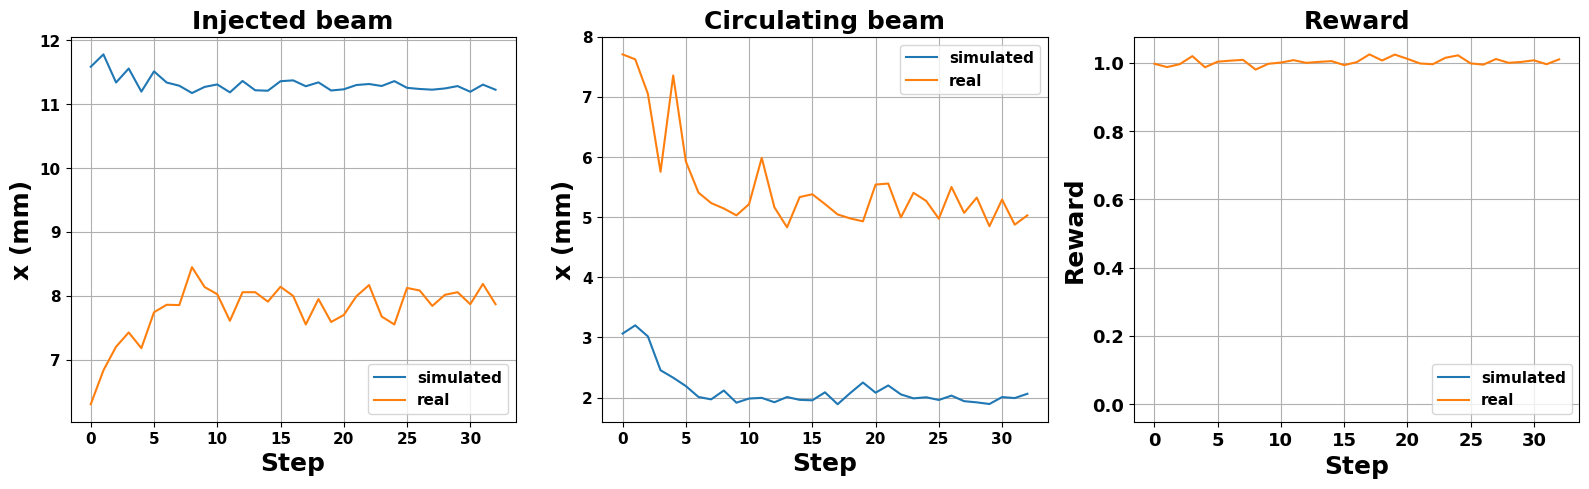

In [22]:
# plot differences between simulated and real horizontal deviations
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

ax[0].plot(np.abs(x_inj) * 1000, label = "simulated")
ax[0].plot(np.abs(x_inj_real) * 1000, label = "real")
ax[0].set_xlabel("Step", fontsize=18)
ax[0].set_ylabel("x (mm)", fontsize=18)
ax[0].grid()
ax[0].legend()
ax[0].set_title('Injected beam', fontsize=18)

ax[1].plot(np.abs(x_circ) * 1000, label = "simulated")
ax[1].plot(np.abs(x_circ_real) * 1000, label = "real")
ax[1].set_xlabel("Step", fontsize=18)
ax[1].set_ylabel("x (mm)", fontsize=18)
ax[1].grid()
ax[1].legend()
ax[1].set_title('Circulating beam', fontsize=18)

ax[2].plot(np.abs(reward), label = "simulated")
ax[2].plot(np.abs(reward_real), label = "real")
ax[2].set_xlabel("Step", fontsize=18)
ax[2].set_ylabel("Reward", fontsize=18)
ax[2].grid()
ax[2].legend()
ax[2].set_title('Reward', fontsize=18)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

fig.tight_layout(pad=1.0)

fig.savefig('plots/sim_reality_gap.pdf', dpi=250)

The simulation over-estimates the deviations of the injected and under-estimates the devations of the circulating beam. This could be caused by a too large estimate of the flat-top.

## Waveform fluctuations

During one episode of the simulation environment, the waveforms are not altered. If the same delays are used at two different steps, identical rewards will be achieved. A simulated episode would cover multiple hours of accelerator operation. The two evaluation episodes on the accelerator were started within half an hour and with the same settings. So comparing the waveforms and rewards at the start of these episodes shows, whether the behaviour of the simulation environment is realistic.

In [11]:
# load logged data of first episode
with open('data/actors_mkp_delays_log_data_rec_True_2024-03-15_17-11-57.354733_beamts_5040_perturbations.pickle', 'rb') as f:
    data = pickle.load(f)

In [12]:
# calculate initial reward
x1bar = np.abs(np.max(data['bpm_pos'][0][1]) - np.min(data['bpm_pos'][0][1])) / 2 / 1000
x2bar = np.abs(np.max(data['bpm_pos'][0][0]) - np.min(data['bpm_pos'][0][0])) / 2 / 1000

reward = -1 * (x1bar ** 2 + x2bar ** 2 + (x1bar - x2bar) ** 2)

initial_reward_1 = 2 * (reward - (-1e-3)) / (-1e-4 - (-1e-3)) - 1
print(initial_reward_1)

1.0534795421308862


In [13]:
# extract initial waveforms
initial_waveforms_1 = data["mkp_waveform_kick_data"][0]

In [15]:
# load logged data of second episode
with open('data/actors_mkp_delays_log_data_rec_True_2024-03-15_17-39-27.504243_beamts_5040_perturbations.pickle', 'rb') as f:
    data = pickle.load(f)

In [16]:
# calculate initial reward
x1bar = np.abs(np.max(data['bpm_pos'][0][1]) - np.min(data['bpm_pos'][0][1])) / 2 / 1000
x2bar = np.abs(np.max(data['bpm_pos'][0][0]) - np.min(data['bpm_pos'][0][0])) / 2 / 1000

reward = -1 * (x1bar ** 2 + x2bar ** 2 + (x1bar - x2bar) ** 2)

initial_reward_2 = 2 * (reward - (-1e-3)) / (-1e-4 - (-1e-3)) - 1
print(initial_reward_2)

1.0204738947776009


In [17]:
# extract initial waveforms
initial_waveforms_2 = data["mkp_waveform_kick_data"][0]

In [18]:
# relative reward difference.
print((initial_reward_1 - initial_reward_2) / initial_reward_2)

0.03234345094195529


The initial rewards differ by more than 3%. The waveforms are compared from the start of the rising edge and from the halfway-point of the rising edge.

In [ ]:
# calcualte relative differences between waveforms
for i in np.arange(0, 16):
    diff = []
    for j in np.arange(0, 2600): 
        if initial_waveforms_1[i][j] >= 0.02 * np.max(initial_waveforms_1[i]): 
            diff.append((initial_waveforms_1[i][j] - initial_waveforms_2[i][j]) / initial_waveforms_2[i][j])
    print(np.max(diff))

In [ ]:
# calcualte relative differences between waveforms
for i in np.arange(0, 16):
    diff = []
    for j in np.arange(0, 2600): 
        if initial_waveforms_1[i][j] >= 0.5 * np.max(initial_waveforms_1[i]): 
            diff.append((initial_waveforms_1[i][j] - initial_waveforms_2[i][j]) / initial_waveforms_2[i][j])
    print(np.max(diff))

The waveforms differ a non-negligibly. The differences are more pronounced at the beginning of the rising edge.